## Разведовательный анализ датасета
Используемый датасет: https://www.kaggle.com/datasets/hm-land-registry/uk-housing-prices-paid

В датасете содержатся данные о продаже недвижимости в Великобритании в период с 1995 г. по 2017 г.

## Импорты
Общие модули, которые будут использованы для анализа данных

In [1]:
# Import other modules not related to PySpark
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
pd.set_option("display.max_columns", None)

Модули библиотеки PySpark, служащие для взаимодействия с движком Spark. Настройка Spark и запуск сессии

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as f
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

## Подготовка данных
Чтение датасета из файла

In [3]:
filename_data = 'data/price_paid_records.csv'
df = spark.read.option("escapeQuotes", "true").csv(filename_data, header=True, inferSchema=True)

Схема датафрейма

In [4]:
df.printSchema()
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

root
 |-- Transaction unique identifier: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Date of Transfer: timestamp (nullable = true)
 |-- Property Type: string (nullable = true)
 |-- Old/New: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Town/City: string (nullable = true)
 |-- District: string (nullable = true)
 |-- County: string (nullable = true)
 |-- PPDCategory Type: string (nullable = true)
 |-- Record Status - monthly file only: string (nullable = true)



,Column Name,Data type
0,Transaction unique identifier,string
1,Price,int
2,Date of Transfer,timestamp
3,Property Type,string
4,Old/New,string
5,Duration,string
6,Town/City,string
7,District,string
8,County,string
9,PPDCategory Type,string


Датасет состоит из следующих столбцов:

- Transaction unique identifier - уникальный идентификатор транзакции
- Price - цена транзакции
- Date of Transfer - дата совершения транзакции
- Property Type - тип собственности
- Old/New - является ли строение новым или старым
- Duration - длительность владения недвижимостью (Freehold, Leasehold)
- Town/City - город, где находится собственность
- District - район города
- County - графство 
- PPDCategory Type - тип записи в реестре PPD
- Record Status - monthly file only - статус записи

In [5]:
df.limit(5).toPandas()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09,S,N,F,GRAYS,THURROCK,THURROCK,A,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A


Описательные характеристики для каждой из колонок

In [6]:
df.describe().toPandas()

,summary,Transaction unique identifier,Price,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type,Record Status - monthly file only
0,count,22489348,22489348,22489348,22489348,22489348,22489348,22489348,22489348,22489348,22489348
1,mean,None,178244.21208765145,None,None,None,None,None,None,None,None
2,stddev,None,390367.65348635067,None,None,None,None,None,None,None,None
3,min,{000000AC-478E-47B3-9B71-7C1E9BB1FEB8},1,D,N,F,ABBOTS LANGLEY,ABERCONWY,AVON,A,A
4,max,{FFFFFE71-D9FC-4232-AD14-819C838EB3D6},98900000,T,Y,U,YSTRAD MEURIG,YORK,YORK,B,A


Последняя колонка не имеет смысла т.к. все значения в ней равны "А", поэтому её можно удалить

In [7]:
df.select("Record Status - monthly file only").distinct().toPandas()

,Record Status - monthly file only
0,A


In [8]:
df = df.drop("Record Status - monthly file only")

Проверим наличие пропущенных значений в датасете

In [9]:
df.select([f.count(f.when(f.isnan(c)|f.col(c).isNull(), c)).alias(c) for c, t in df.dtypes if t != "timestamp"]).toPandas()

,Transaction unique identifier,Price,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type
0,0,0,0,0,0,0,0,0,0


Удалим выбросы используя межквартильное расстояние

In [10]:
def remove_outliers(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return df.where((col(column) >= low) & (col(column) <= high))

In [11]:
df = remove_outliers(df, "Price")

In [13]:
df.describe().toPandas()

,summary,Transaction unique identifier,Price,Property Type,Old/New,Duration,Town/City,District,County,PPDCategory Type
0,count,21115729,21115729,21115729,21115729,21115729,21115729,21115729,21115729,21115729
1,mean,None,140601.0057929802,None,None,None,None,None,None,None
2,stddev,None,86672.018098033,None,None,None,None,None,None,None
3,min,{000000AC-478E-47B3-9B71-7C1E9BB1FEB8},1,D,N,F,ABBOTS LANGLEY,ABERCONWY,AVON,A
4,max,{FFFFFE71-D9FC-4232-AD14-819C838EB3D6},405600,T,Y,U,YSTRAD MEURIG,YORK,YORK,B


Преобразовываем колонку 'PPDCategory Type' к числовому типу

In [14]:
@udf(returnType=IntegerType())
def convert_category(category):
    return ord(category) - ord('A')

df = df.withColumn('additional_entry', convert_category('PPDCategory Type')).drop('PPDCategory Type')

df.limit(10).toPandas()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Duration,Town/City,District,County,additional_entry
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,0
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09,S,N,F,GRAYS,THURROCK,THURROCK,0
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,0
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,0
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,0
5,{895E4E63-203F-476A-9AA9-42389DD0AE5C},81750,1995-05-19,S,N,F,SALISBURY,SALISBURY,WILTSHIRE,0
6,{FB195C27-E790-45FD-847A-4238BC94546A},56000,1995-03-10,S,N,F,WITNEY,WEST OXFORDSHIRE,OXFORDSHIRE,0
7,{1D6B01EC-DC33-4147-8A21-4238BEB2D4C1},31000,1995-03-02,S,N,F,ST. AUSTELL,RESTORMEL,CORNWALL,0
8,{B8D0F817-4553-448D-A2C1-4238BF81C6FA},82000,1995-06-16,S,N,F,GREENFORD,EALING,GREATER LONDON,0
9,{6DD27423-CC39-4B31-A848-4238D58268D4},10000,1995-05-17,T,N,F,FERNDALE,RHONDDA,MID GLAMORGAN,0


Получаем список уникальных значений в колонке 'Duration', отфильтровываем значения 'U' - неизвестная длительность

In [15]:
df.groupBy('Duration').count().toPandas()

,Duration,count
0,F,16073453
1,L,5041637
2,U,639


In [16]:
df = df.where(col('Duration') != 'U')

Преобразуем колонку 'Duration' к числовому типу

In [17]:
@udf(returnType=IntegerType())
def convert_duration(duration):
    return int(duration == 'F')

df = df.withColumn('freehold', convert_duration('Duration')).drop('Duration')

df.limit(10).toPandas()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Old/New,Town/City,District,County,additional_entry,freehold
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18,T,N,OLDHAM,OLDHAM,GREATER MANCHESTER,0,1
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09,S,N,GRAYS,THURROCK,THURROCK,0,1
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30,T,N,HIGHBRIDGE,SEDGEMOOR,SOMERSET,0,1
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24,T,N,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,0,1
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23,S,N,WAKEFIELD,LEEDS,WEST YORKSHIRE,0,1
5,{895E4E63-203F-476A-9AA9-42389DD0AE5C},81750,1995-05-19,S,N,SALISBURY,SALISBURY,WILTSHIRE,0,1
6,{FB195C27-E790-45FD-847A-4238BC94546A},56000,1995-03-10,S,N,WITNEY,WEST OXFORDSHIRE,OXFORDSHIRE,0,1
7,{1D6B01EC-DC33-4147-8A21-4238BEB2D4C1},31000,1995-03-02,S,N,ST. AUSTELL,RESTORMEL,CORNWALL,0,1
8,{B8D0F817-4553-448D-A2C1-4238BF81C6FA},82000,1995-06-16,S,N,GREENFORD,EALING,GREATER LONDON,0,1
9,{6DD27423-CC39-4B31-A848-4238D58268D4},10000,1995-05-17,T,N,FERNDALE,RHONDDA,MID GLAMORGAN,0,1


Преобразуем колонку 'Old/New' к числовому типу

In [18]:
@udf(returnType=IntegerType())
def convert_oldnew(old_new):
    return int(old_new == 'Y')

df = df.withColumn('new', convert_oldnew('Old/New')).drop('Old/New')

df.limit(10).toPandas()

,Transaction unique identifier,Price,Date of Transfer,Property Type,Town/City,District,County,additional_entry,freehold,new
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18,T,OLDHAM,OLDHAM,GREATER MANCHESTER,0,1,0
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09,S,GRAYS,THURROCK,THURROCK,0,1,0
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30,T,HIGHBRIDGE,SEDGEMOOR,SOMERSET,0,1,0
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24,T,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,0,1,0
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23,S,WAKEFIELD,LEEDS,WEST YORKSHIRE,0,1,0
5,{895E4E63-203F-476A-9AA9-42389DD0AE5C},81750,1995-05-19,S,SALISBURY,SALISBURY,WILTSHIRE,0,1,0
6,{FB195C27-E790-45FD-847A-4238BC94546A},56000,1995-03-10,S,WITNEY,WEST OXFORDSHIRE,OXFORDSHIRE,0,1,0
7,{1D6B01EC-DC33-4147-8A21-4238BEB2D4C1},31000,1995-03-02,S,ST. AUSTELL,RESTORMEL,CORNWALL,0,1,0
8,{B8D0F817-4553-448D-A2C1-4238BF81C6FA},82000,1995-06-16,S,GREENFORD,EALING,GREATER LONDON,0,1,0
9,{6DD27423-CC39-4B31-A848-4238D58268D4},10000,1995-05-17,T,FERNDALE,RHONDDA,MID GLAMORGAN,0,1,0


Преобразуем колонку 'Property Type' к кодировке one-hot, используя StringIndexer и OneHotEncoder

In [19]:
indexer = StringIndexer(inputCol="Property Type", outputCol="property_type_index").fit(df)
df = indexer.transform(df)

onehot = OneHotEncoder(inputCol="property_type_index", outputCol="property_type_onehot")
onehot.setDropLast(False)
df = onehot.fit(df).transform(df)

column_names = {
    "D": "detached",
    "S": "semi_detached",
    "T": "terraced",
    "F": "flats",
    "O": "other",
}

@udf(returnType=StringType())
def convert_property_type(property_type):
    return column_names[property_type]
    
df = df.withColumn("property_type", convert_property_type("Property Type")).drop("Property Type")

new_columns = [column_names[key] for key in indexer.labels]

@udf(returnType=IntegerType())
def get_item(vector, item):
    return int(vector[item])

for i, column in enumerate(new_columns):
    df = df.withColumn(column, get_item("property_type_onehot", lit(i)))
    
df = df.drop("property_type_index", "property_type_onehot")

OneHotEncoder_2785ad37b2c8

In [20]:
df.limit(10).toPandas()

,Transaction unique identifier,Price,Date of Transfer,Town/City,District,County,additional_entry,freehold,new,property_type,terraced,semi_detached,detached,flats,other
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18,OLDHAM,OLDHAM,GREATER MANCHESTER,0,1,0,terraced,1,0,0,0,0
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09,GRAYS,THURROCK,THURROCK,0,1,0,semi_detached,0,1,0,0,0
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30,HIGHBRIDGE,SEDGEMOOR,SOMERSET,0,1,0,terraced,1,0,0,0,0
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,0,1,0,terraced,1,0,0,0,0
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23,WAKEFIELD,LEEDS,WEST YORKSHIRE,0,1,0,semi_detached,0,1,0,0,0
5,{895E4E63-203F-476A-9AA9-42389DD0AE5C},81750,1995-05-19,SALISBURY,SALISBURY,WILTSHIRE,0,1,0,semi_detached,0,1,0,0,0
6,{FB195C27-E790-45FD-847A-4238BC94546A},56000,1995-03-10,WITNEY,WEST OXFORDSHIRE,OXFORDSHIRE,0,1,0,semi_detached,0,1,0,0,0
7,{1D6B01EC-DC33-4147-8A21-4238BEB2D4C1},31000,1995-03-02,ST. AUSTELL,RESTORMEL,CORNWALL,0,1,0,semi_detached,0,1,0,0,0
8,{B8D0F817-4553-448D-A2C1-4238BF81C6FA},82000,1995-06-16,GREENFORD,EALING,GREATER LONDON,0,1,0,semi_detached,0,1,0,0,0
9,{6DD27423-CC39-4B31-A848-4238D58268D4},10000,1995-05-17,FERNDALE,RHONDDA,MID GLAMORGAN,0,1,0,terraced,1,0,0,0,0


Подготовка данных для графиков

In [21]:
property_type = df.groupBy("property_type").count().toPandas()
freehold = df.groupBy("freehold").count().toPandas()
new = df.groupBy("new").count().toPandas()
additional_price = df.groupBy("additional_entry").count().toPandas()

limited_df = df.where(df.Price <= 1_000_000)
interval = limited_df.groupBy().max("Price").first()["max(Price)"] // 30
price = limited_df.withColumn("price_hist", (col("Price") / interval).astype(IntegerType()) * interval).groupBy("price_hist").count().orderBy("price_hist").toPandas()

Построение круговых диаграмм

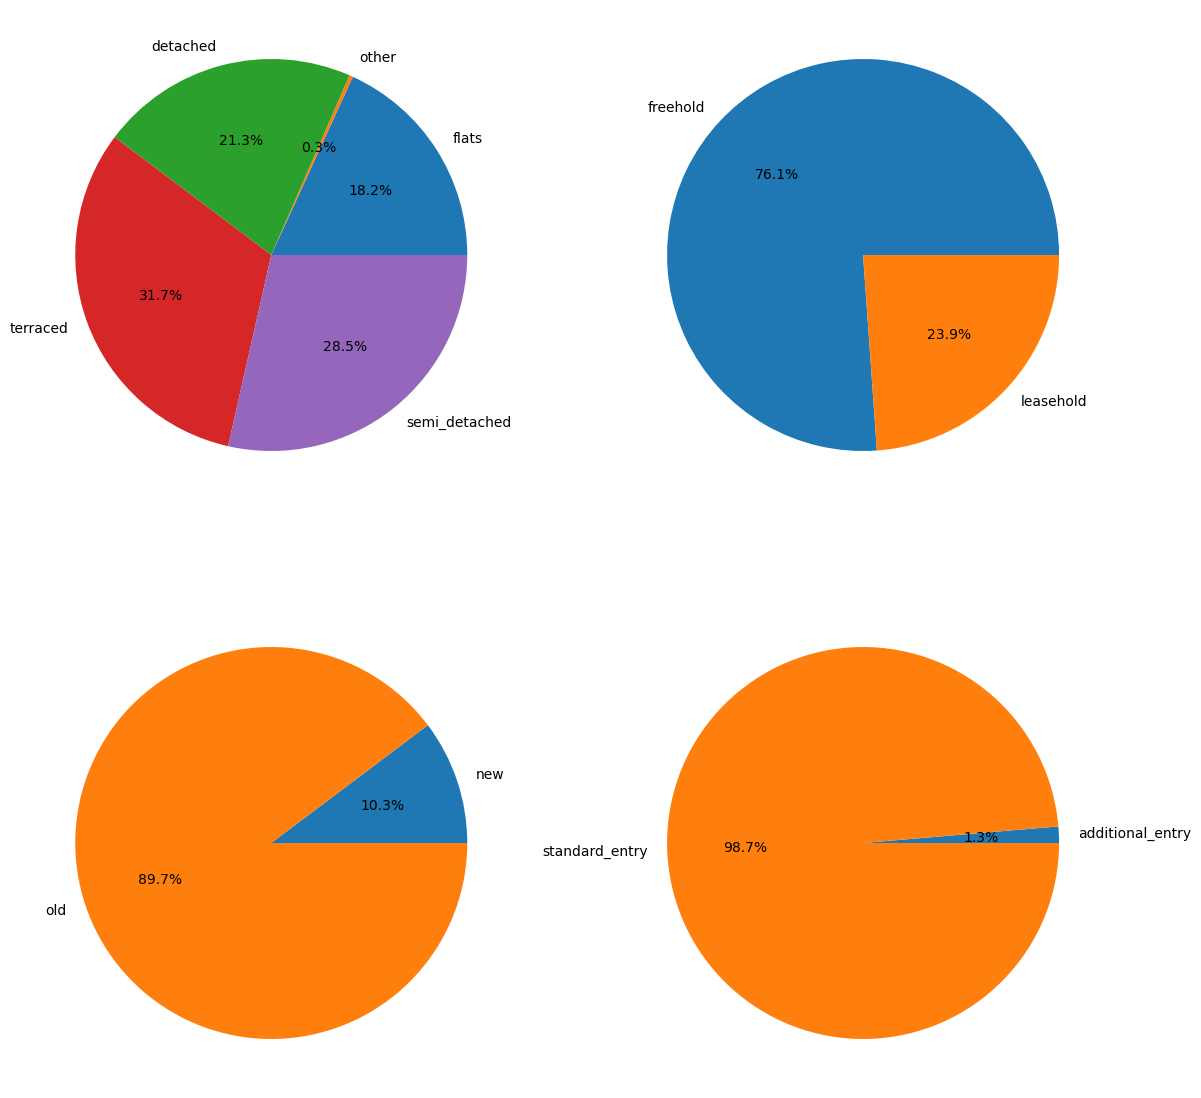

In [22]:
figure, axes = plt.subplots(2, 2, figsize=(14, 14))
_ = axes[0][0].pie(property_type["count"], labels=property_type["property_type"], autopct="%.1f%%")
_ = axes[0][1].pie(freehold["count"], labels=["freehold", "leasehold"], autopct="%.1f%%")
_ = axes[1][0].pie(new["count"], labels=["new", "old"], autopct="%.1f%%")
_ = axes[1][1].pie(additional_price["count"], labels=["additional_entry", "standard_entry"], autopct="%.1f%%")

Построим гистрограмму количества по типам собственности

<AxesSubplot: xlabel='property_type'>

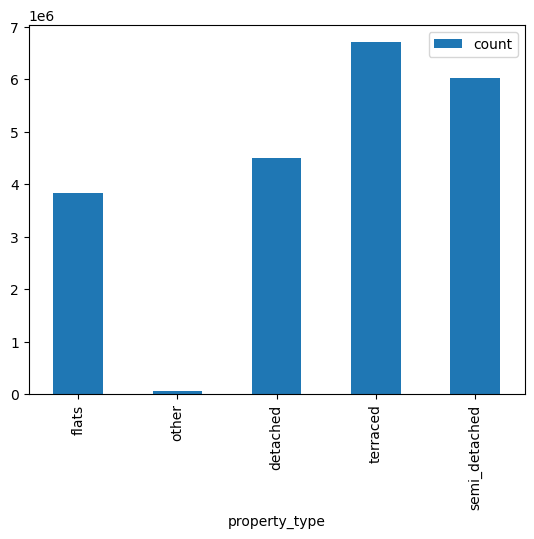

In [23]:
property_type.plot.bar(y="count", x="property_type")

Построение гистограммы распределения количества транзакций по цене

<AxesSubplot: xlabel='Price', ylabel='Count'>

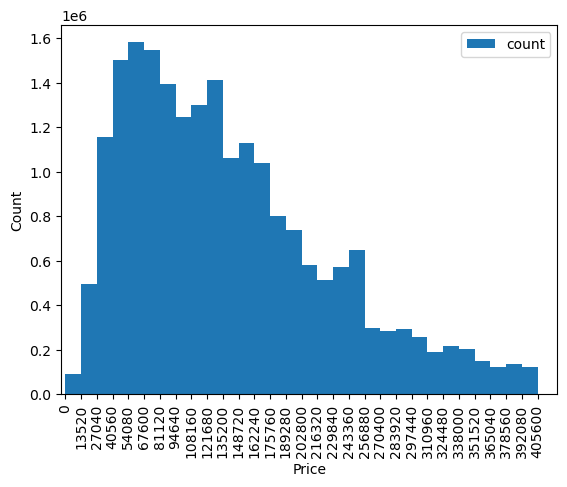

In [24]:
price.plot.bar(x="price_hist", align="edge", width=1, xlabel="Price", ylabel="Count")

Групируем датафрейм по типу собственности и строим гистрограмму распределения количства транзакций по цене

<AxesSubplot: xlabel='Price', ylabel='Count'>

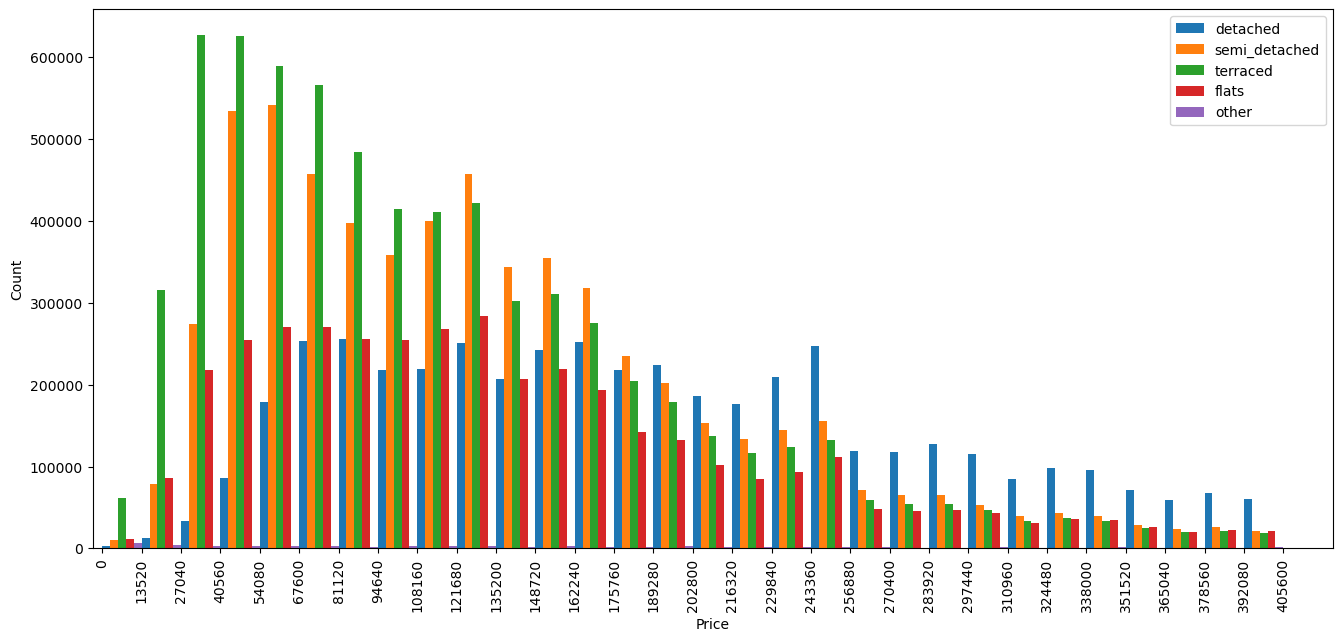

In [25]:
columns = list(column_names.values())
hist_df = limited_df.withColumn("price_hist", (col("Price") / interval).astype(IntegerType()) * interval)
dataframes = []
for name in columns:
    dataframe = hist_df.where(hist_df.property_type == name).groupBy("price_hist").count().orderBy("price_hist").withColumnRenamed("count", name)
    dataframes.append(dataframe)

first, *other = dataframes
for dataframe in other:
    first = first.join(dataframe, ["price_hist"], "full")
    
price_grouped = first.fillna(0).orderBy("price_hist").withColumnRenamed("price_hist", "price").toPandas()

price_grouped.plot.bar(x="price", align="edge", width=1, xlabel="Price", ylabel="Count", figsize=(16, 7))

Построим диаграмму распределение суммарной стоимости проданной недвижимости по годам

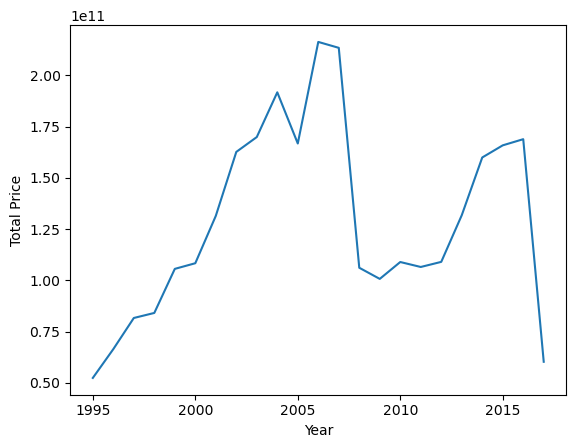

In [26]:
df = df.withColumn("year", f.year("Date of Transfer"))
yearly_sales = df.groupBy("year").sum("Price").withColumnRenamed("sum(Price)", "Total Price").orderBy("year").toPandas()
ax = yearly_sales.plot.line(x="year", xlabel="Year", ylabel="Total Price")
ax.legend().remove()

Диаграмма распределения количества проданной недвижимсоти по годам

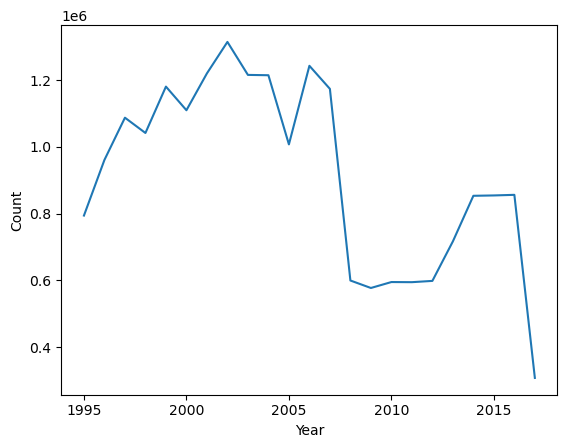

In [27]:
yearly_sales_count = df.groupBy("year").count().orderBy("year").toPandas()
ax = yearly_sales_count.plot.line(x="year", xlabel="Year", ylabel="Count")
ax.legend().remove()

In [28]:
df = df.drop("year")
df.write.mode("overwrite").option("header", True).csv("data/prepered.csv")